In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/processed/train_FD001_clean.csv')
df.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
CLIP = 120
max_cycles = df.groupby('unit_number')['time_cycles'].transform('max')
df['RUL'] = max_cycles - df['time_cycles']
df['RUL'] = df['RUL'].clip(upper=CLIP)
df[['unit_number', 'RUL', 'time_cycles']]

,unit_number,RUL,time_cycles
0,1,120,1
1,1,120,2
2,1,120,3
3,1,120,4
4,1,120,5
...,...,...,...
20626,100,4,196
20627,100,3,197
20628,100,2,198
20629,100,1,199


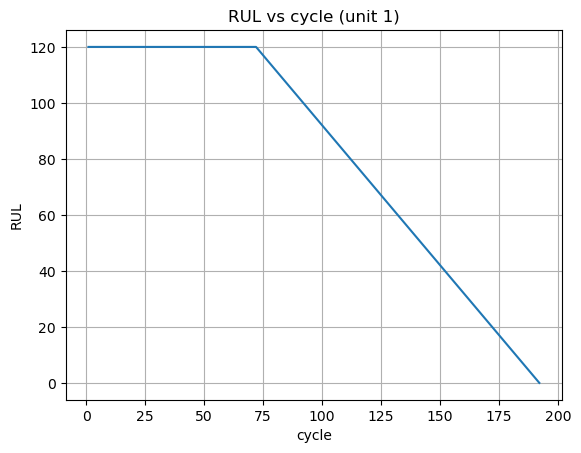

In [4]:
u1 = df[df['unit_number']==1]

plt.plot(u1['time_cycles'], u1['RUL'])
plt.title('RUL vs cycle (unit 1)')
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()
plt.close()

In [5]:
cols = [c for c in df.columns if 'sensor' in c or 'setting' in c]
threshold = 1e-5

low_var = df[cols].var()[df[cols].var() < threshold].index
low_var

Index(['setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_5',
       'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'],
      dtype='object')

In [6]:
df_clean = df.drop(columns=low_var)
df_clean.head()

,unit_number,time_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,120
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,120
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,120
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,120
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,120


In [7]:
cols_clean = [c for c in df_clean.columns if 'sensor' in c or 'setting' in c]
window = 5

def rolling_mean(x):
    return x.rolling(window, min_periods=1).mean()

def rolling_std(x):
    return x.rolling(window, min_periods=1).std()

def diff_inst(x):
    return x.diff()

for col in cols_clean :
    df_clean[f'{col}_mean_{window}'] = df_clean.groupby('unit_number')[col].transform(rolling_mean)
    df_clean[f'{col}_std_{window}'] = df_clean.groupby('unit_number')[col].transform(rolling_std)
    df_clean[f'{col}_diff'] = df_clean.groupby('unit_number')[col].transform(diff_inst)

df_clean = df_clean.fillna(0)
df_clean.head()

,unit_number,time_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_15_diff,sensor_17_mean_5,sensor_17_std_5,sensor_17_diff,sensor_20_mean_5,sensor_20_std_5,sensor_20_diff,sensor_21_mean_5,sensor_21_std_5,sensor_21_diff
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,0.0000,392.000000,0.000000,0.0,39.060000,0.000000,0.00,23.419000,0.000000,0.0000
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,0.0123,392.000000,0.000000,0.0,39.030000,0.042426,-0.06,23.421300,0.003253,0.0046
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,-0.0140,391.333333,1.154701,-2.0,39.003333,0.055076,-0.05,23.395600,0.044573,-0.0794
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,-0.0496,391.500000,1.000000,2.0,38.972500,0.076322,-0.07,23.390175,0.037977,0.0297
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,0.0612,391.800000,1.095445,1.0,38.958000,0.073621,0.02,23.393020,0.033498,0.0305


In [8]:
df_RUL = df_clean.drop(columns=['unit_number','time_cycles'])
df_RUL.head()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,...,sensor_15_diff,sensor_17_mean_5,sensor_17_std_5,sensor_17_diff,sensor_20_mean_5,sensor_20_std_5,sensor_20_diff,sensor_21_mean_5,sensor_21_std_5,sensor_21_diff
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,...,0.0000,392.000000,0.000000,0.0,39.060000,0.000000,0.00,23.419000,0.000000,0.0000
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,...,0.0123,392.000000,0.000000,0.0,39.030000,0.042426,-0.06,23.421300,0.003253,0.0046
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,...,-0.0140,391.333333,1.154701,-2.0,39.003333,0.055076,-0.05,23.395600,0.044573,-0.0794
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,...,-0.0496,391.500000,1.000000,2.0,38.972500,0.076322,-0.07,23.390175,0.037977,0.0297
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,...,0.0612,391.800000,1.095445,1.0,38.958000,0.073621,0.02,23.393020,0.033498,0.0305


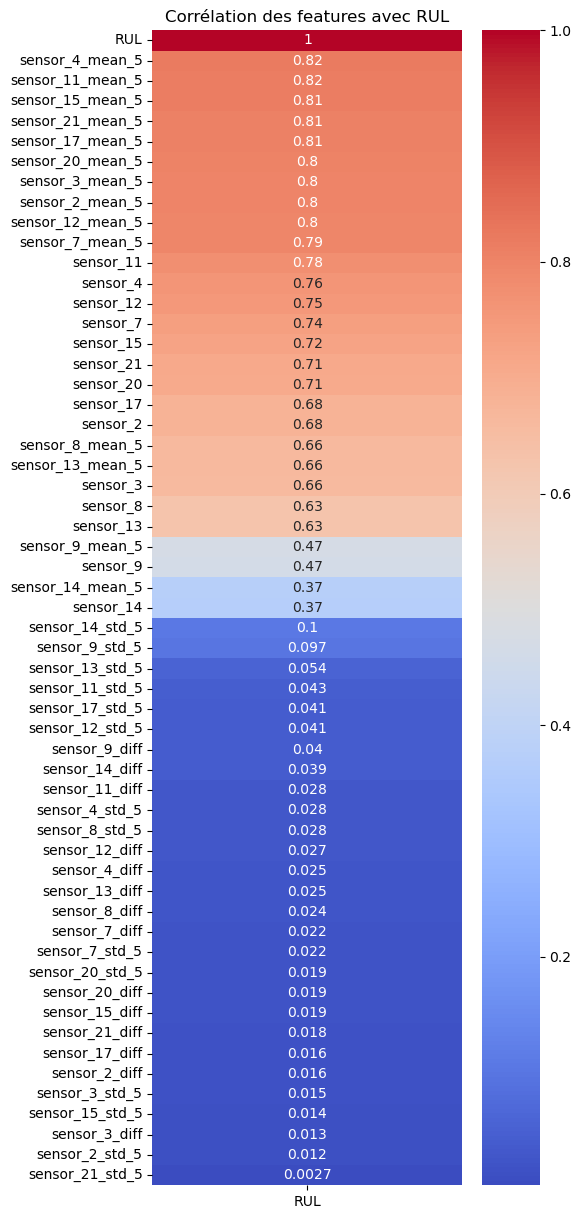

In [9]:
corr = df_RUL.corr()['RUL'].abs().sort_values(ascending=False)

plt.figure(figsize=(5,15))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Corrélation des features avec RUL')

plt.show()
plt.close()

In [10]:
sample_features = corr.index[1:11]
sample_units = df_clean['unit_number'].unique()[:5]

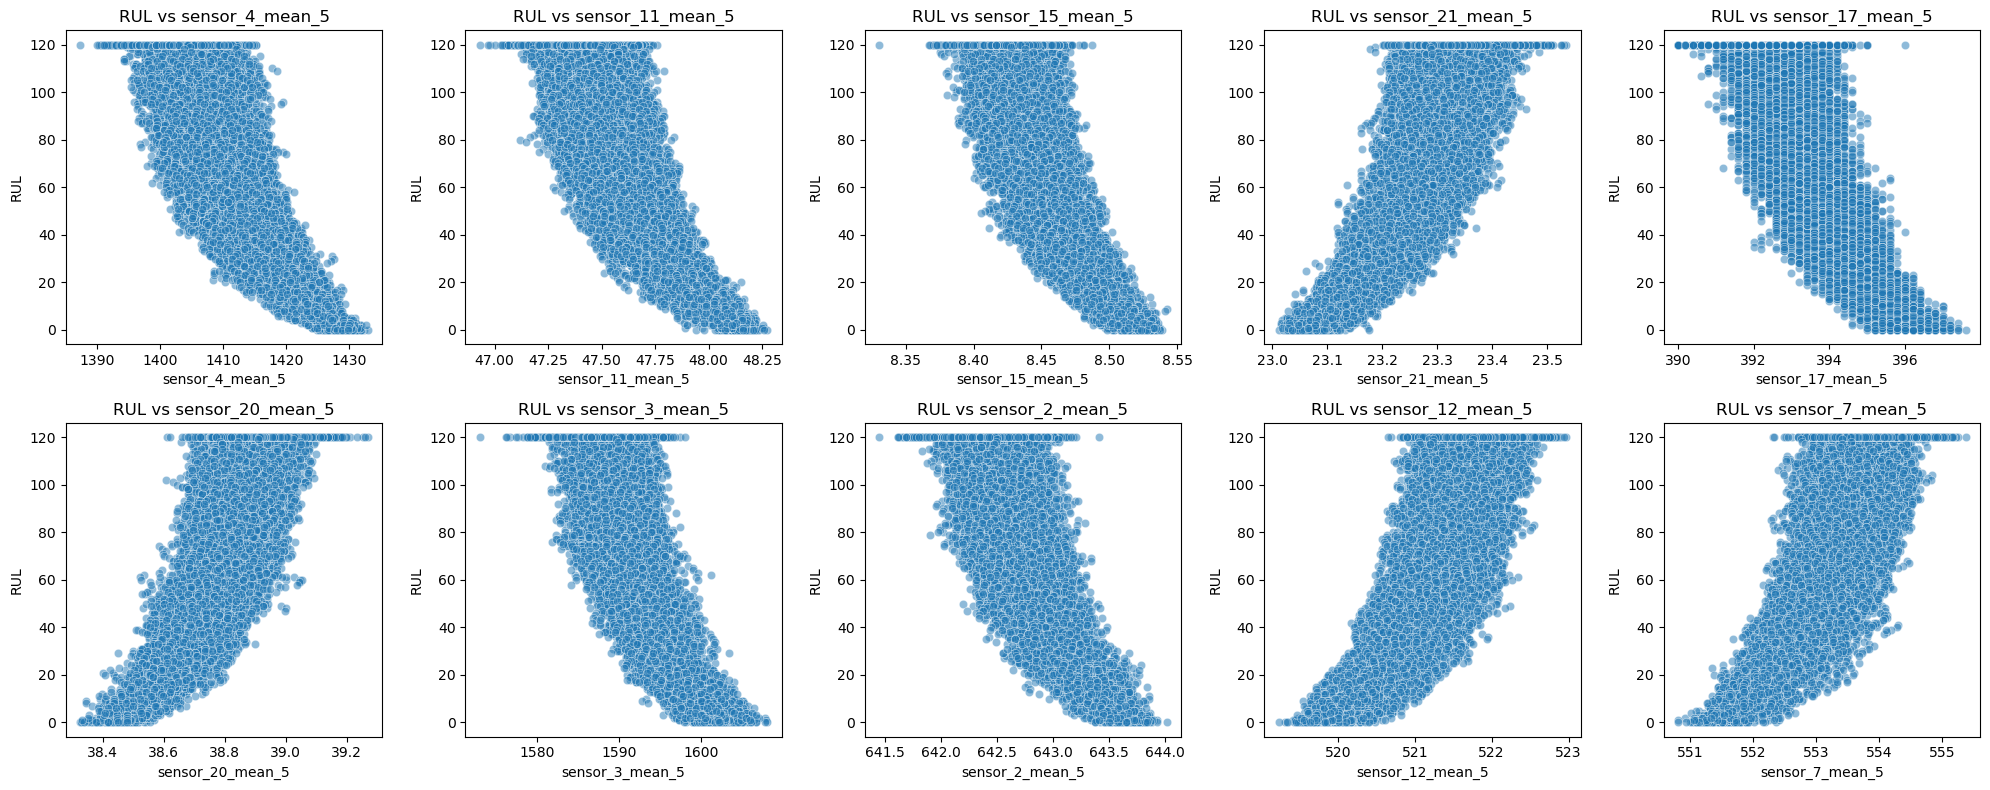

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))  
axes = axes.flatten()

for ax, feature in zip(axes, sample_features):
    sns.scatterplot(x=df_clean[feature], y=df_clean['RUL'], alpha=0.5, ax=ax)
    ax.set_title(f'RUL vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('RUL')

plt.tight_layout()
plt.show()
plt.close()

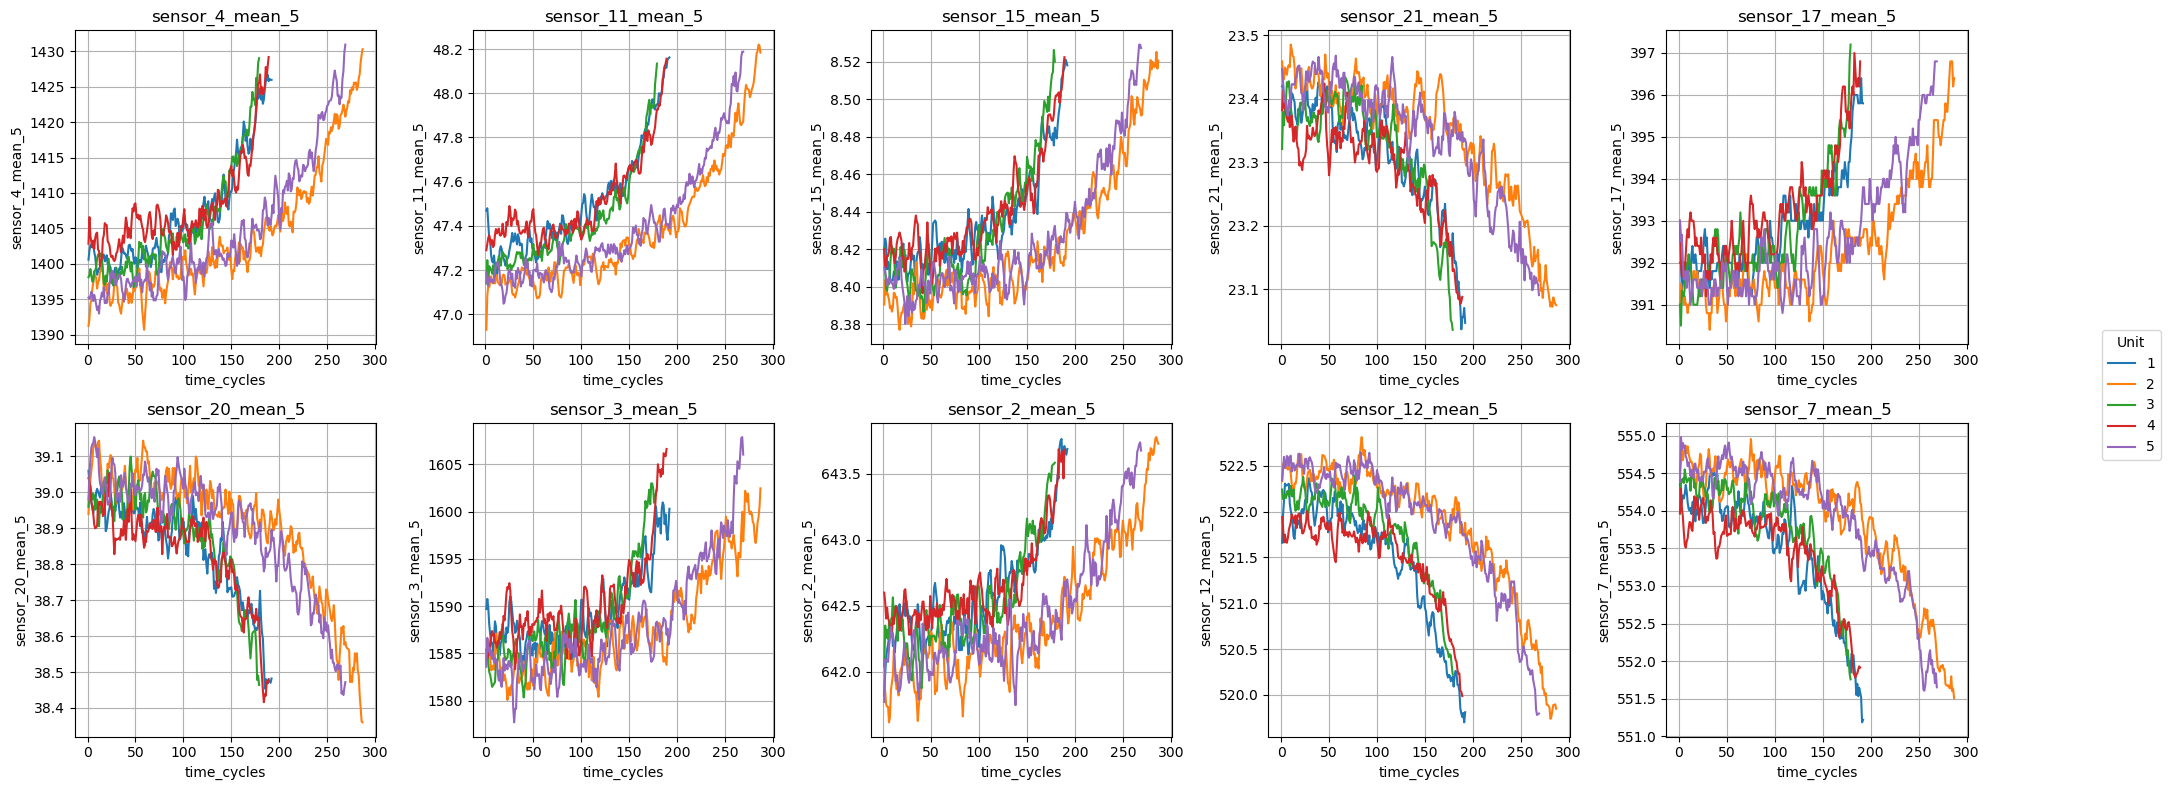

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))
axes = axes.flatten()

for ax, feature in zip(axes, sample_features):
    for unit in sample_units:
        subset = df_clean[df_clean['unit_number']==unit]
        ax.plot(subset['time_cycles'], subset[feature], label=f'Unit {unit}')
    ax.set_title(feature)
    ax.set_xlabel('time_cycles')
    ax.set_ylabel(feature)
    ax.grid(True)

fig.legend(sample_units, title='Unit', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.show()
plt.close()

In [13]:
feature_threshold = 0.1
top_features = corr[corr > feature_threshold].index.drop('RUL')

In [14]:
features = list(top_features)
df_model = df_clean[['unit_number', 'time_cycles'] + features + ['RUL']]

print(df_model.shape)
df_model.head()

(20631, 32)


,unit_number,time_cycles,sensor_4_mean_5,sensor_11_mean_5,sensor_15_mean_5,sensor_21_mean_5,sensor_17_mean_5,sensor_20_mean_5,sensor_3_mean_5,sensor_2_mean_5,...,sensor_13_mean_5,sensor_3,sensor_8,sensor_13,sensor_9_mean_5,sensor_9,sensor_14_mean_5,sensor_14,sensor_14_std_5,RUL
0,1,1,1400.600000,47.470,8.419500,23.419000,392.000000,39.060000,1589.700000,641.820000,...,2388.020,1589.70,2388.06,2388.02,9046.190000,9046.19,8138.620000,8138.62,0.000000,120
1,1,2,1401.870000,47.480,8.425650,23.421300,392.000000,39.030000,1590.760000,641.985000,...,2388.045,1591.82,2388.04,2388.07,9045.130000,9044.07,8135.055000,8131.49,5.041671,120
2,1,3,1402.646667,47.410,8.423033,23.395600,391.333333,39.003333,1589.836667,642.106667,...,2388.040,1587.99,2388.08,2388.03,9047.733333,9052.94,8134.446667,8133.23,3.717450,120
3,1,4,1402.452500,47.340,8.409325,23.390175,391.500000,38.972500,1588.075000,642.167500,...,2388.050,1582.79,2388.11,2388.08,9048.170000,9049.48,8134.292500,8133.83,3.050906,120
4,1,5,1403.206000,47.328,8.413340,23.393020,391.800000,38.958000,1587.030000,642.208000,...,2388.048,1582.85,2388.06,2388.04,9049.566000,9055.15,8134.194000,8133.80,2.651326,120


In [15]:
df_model.to_csv('../data/processed/train_FD001_features.csv', index=False)